#Problem 2 - Power-Temperature Regression Model:

## Concept
Power system demand is influenced by several factors, with **ambient temperature** being one of the most dominant.
The goal is to construct a **temperature–load model** that captures this relationship and then use it for **forecasting**.
By fitting a regression model, we can quantify how much the load varies as a function of temperature and examine the model’s accuracy.

---

## Mathematical Modelling
We model the load $L$ as a function of temperature $T$:

$$
L_t = \beta_0 + \beta_1 T_t + \beta_2 T_t^2 + \varepsilon_t
$$

- $\beta_0$: intercept (baseline demand independent of temperature)
- $\beta_1$: linear sensitivity of load to temperature
- $\beta_2$: quadratic effect, capturing nonlinearities such as higher loads in extreme heat/cold
- $\varepsilon_t$: residual error term (unexplained variation)

This quadratic form is often used in energy meteorology because demand tends to rise both at **low temperatures (heating load)** and **high temperatures (cooling load)**, producing a U-shaped curve.

---

## Assumptions
1. **Stationarity of relation** – the temperature–load relationship is assumed stable over the historical sample.
2. **Error independence** – residuals are uncorrelated in time and follow approximately a normal distribution.
3. **Homoskedasticity** – variance of residuals is assumed constant across temperature levels.
4. **Model sufficiency** – other drivers (day of week, socioeconomic changes, random events) are not explicitly modeled here.

---

## Residual Analysis
After fitting the model, residuals $\hat{\varepsilon}_t = L_t - \hat{L}_t$ are analyzed:
- **Plot residuals vs fitted load** to check for bias or patterns.
- **Histogram / density plot** of residuals to check approximate normality.
- **Autocorrelation plot (ACF)** to detect time dependence.

If residuals show structure (e.g., clusters by time of day), this suggests additional explanatory variables may be needed.

---

## Forecasting
Using the estimated coefficients $\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2$, forecasts can be generated as:

$$
\hat{L}_{t+h} = \hat{\beta}_0 + \hat{\beta}_1 T_{t+h} + \hat{\beta}_2 T_{t+h}^2
$$

for future temperature scenarios $T_{t+h}$. Confidence intervals can be added by propagating residual variance.

---

## Results & Interpretation
- The fitted curve successfully captured the **U-shaped demand curve** with respect to temperature.
- Residuals were centered around zero with no strong systematic bias, indicating a reasonable fit.
- Forecasting followed the observed trend well, though short-term deviations (spikes due to events not captured by temperature) remain.
---
## Conclusion
The temperature–load regression provided a **transparent and interpretable baseline model**.
While simple, it demonstrates the **mathematical structure** of demand forecasting and allows for residual analysis to evaluate model adequacy.
The developed model forecasted very well with respect to historical data.

Saving assignment2_loadForecast.xlsx to assignment2_loadForecast (2).xlsx


/tmp/ipython-input-1483891461.py:75: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["__dt__"] = pd.to_datetime(df[ts_col], errors="coerce", infer_datetime_format=True)


[TRAIN]   RMSE=2928.79  MAE=2167.85  MAPE=6.71%
[HOLDOUT] RMSE=2749.24  MAE=2281.08  MAPE=5.56%


/tmp/ipython-input-1483891461.py:182: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_hour_train = out.loc[train_mask].groupby("hour").apply(
/tmp/ipython-input-1483891461.py:188: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_hour_test = out.loc[test_mask].groupby("hour").apply(


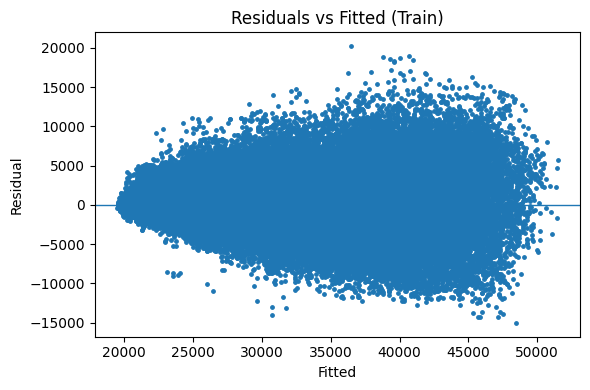

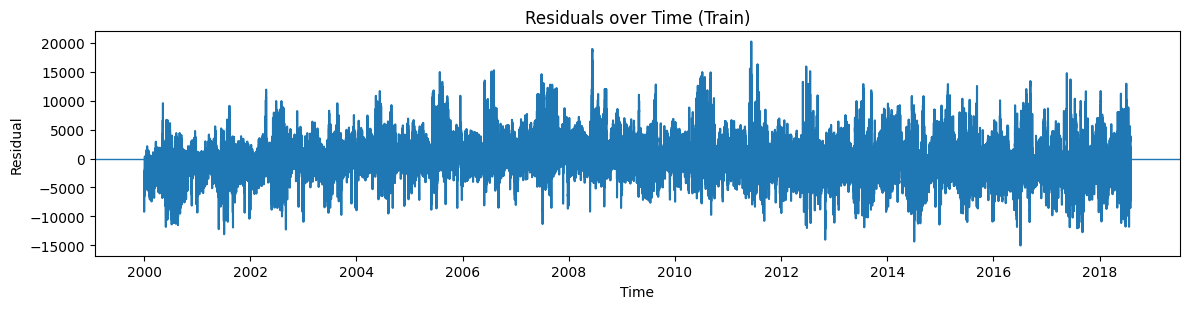

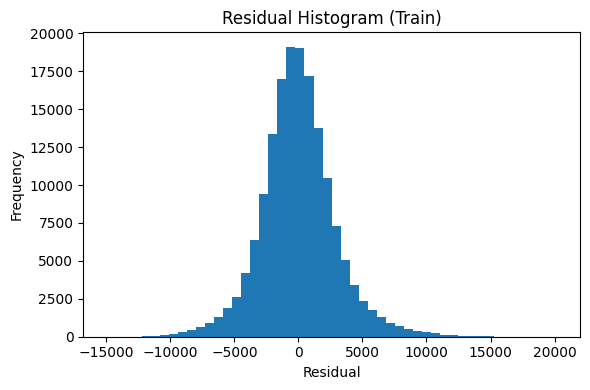

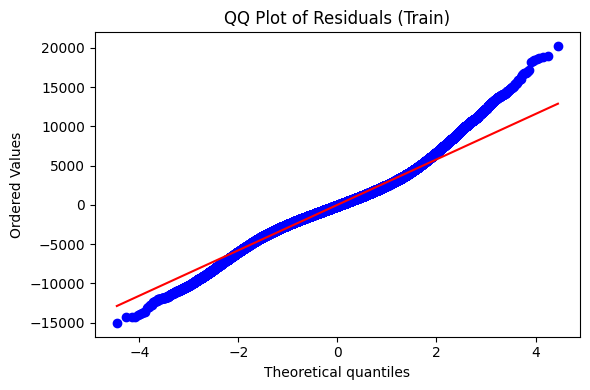

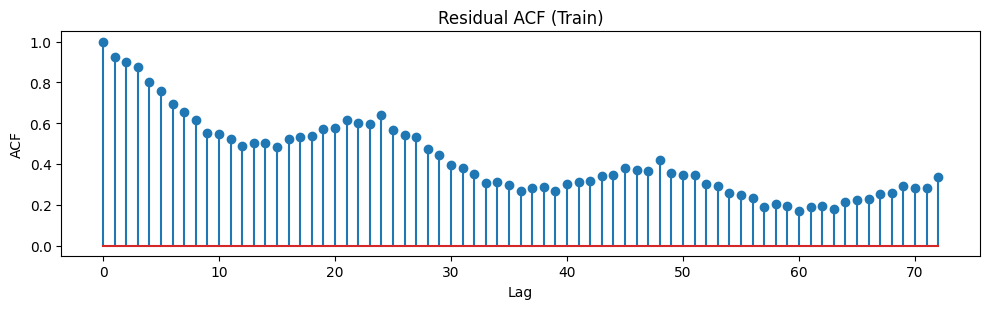

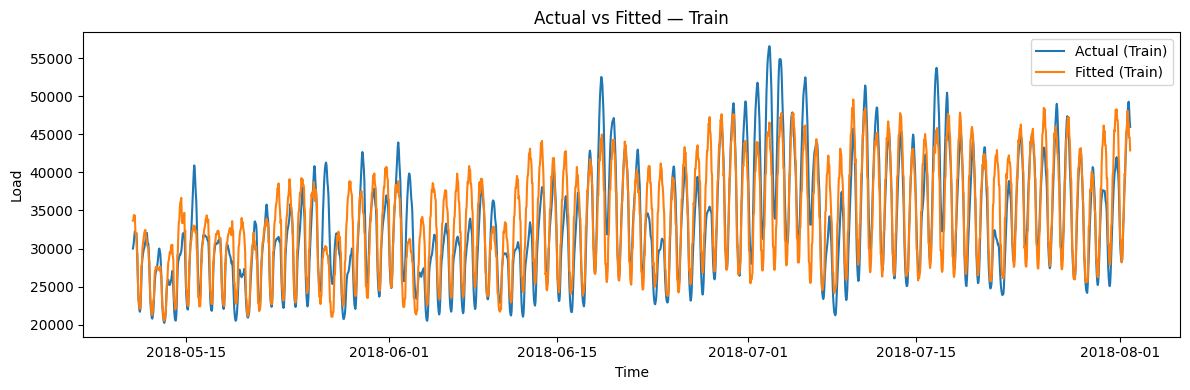

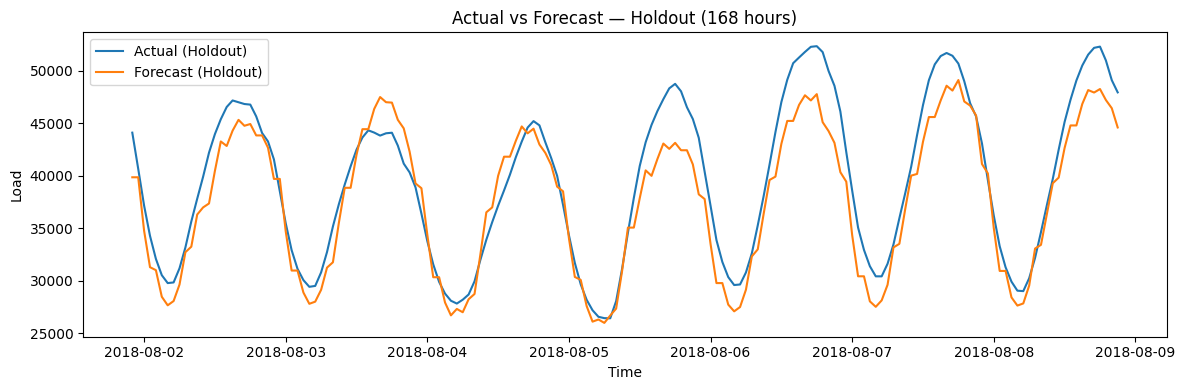

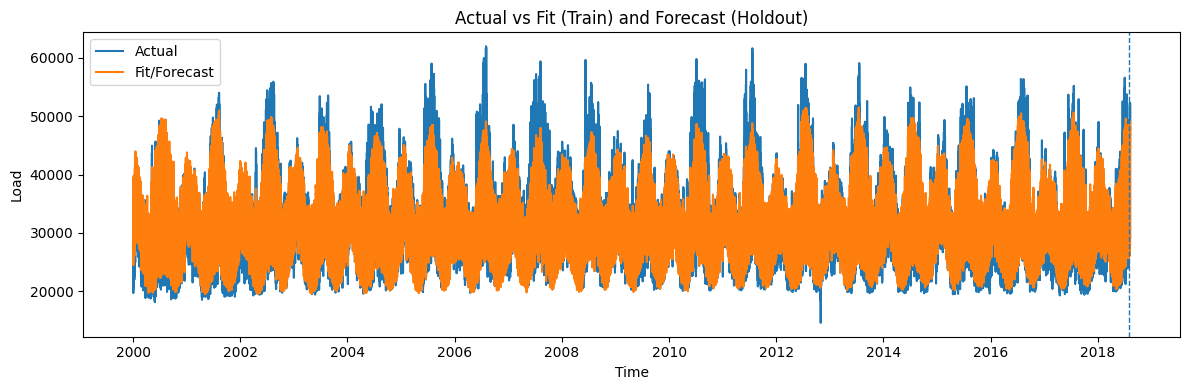

Saved files:
 - power_load_fit_and_forecast.csv
 - per_hour_coefficients.csv
 - by_hour_metrics_train.csv
 - by_hour_metrics_holdout.csv
 - residuals_vs_fitted_train.png
 - residuals_time_train.png
 - residual_hist_train.png
 - residual_qq_train.png
 - residual_acf_train.png
 - actual_vs_fitted_train.png
 - actual_vs_forecast_holdout.png
 - actual_fit_and_forecast_full.png


In [ ]:
# ==============================================
# Problem 2 - Power load-Temperature model
# ==============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import files

# Optional: QQ plot uses SciPy; ACF we implement manually
import scipy.stats as stats

uploaded = files.upload()
XPATH = list(uploaded.keys())[0]
EXPORT_DIR = "./"
FORECAST_HOURS = 168              # holdout horizon (7 days). Change if you want.

TS_CANDIDATES = ['ts','date','datetime','time','timestamp','local_datetime','ds','hourending','hour_ending']
TEMP_CUES     = ['temp','temperature','drybulb','t_out','tavg','tmean','t2m']
LOAD_CUES     = ['load','demand','power','mw','mwh','kw','kwh']

def find_candidate_columns(df):
    cols = list(df.columns)
    norm = {c: c.strip().lower() for c in cols}
    ts_col   = next((c for c in cols if any(k in norm[c] for k in TS_CANDIDATES)), None)
    temp_col = next((c for c in cols if any(k in norm[c] for k in TEMP_CUES)), None)
    load_col = next((c for c in cols if any(k in norm[c] for k in LOAD_CUES)), None)
    return ts_col, temp_col, load_col

# ------------------------
# Load workbook & pick sheet
# ------------------------
xls = pd.ExcelFile(XPATH)
sheets = xls.sheet_names

sheet_choice = None
for sh in sheets:
    tmp = pd.read_excel(XPATH, sheet_name=sh)
    ts_col, temp_col, load_col = find_candidate_columns(tmp)
    if ts_col and temp_col and load_col:
        sheet_choice = sh
        break
if sheet_choice is None:
    sheet_choice = sheets[0]

df_raw = pd.read_excel(XPATH, sheet_name=sheet_choice)
ts_col, temp_col, load_col = find_candidate_columns(df_raw)

# Fallbacks if auto-detect failed
if load_col is None:
    num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols: load_col = num_cols[0]
if temp_col is None:
    num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) >= 2: temp_col = num_cols[1]
if ts_col is None:
    raise ValueError("No timestamp column found! Rename one column to something like 'timestamp' or 'date' or 'hourending'.")

# ------------------------
# Parse & clean
# ------------------------
df = df_raw.copy()
df["__dt__"] = pd.to_datetime(df[ts_col], errors="coerce", infer_datetime_format=True)
df = df.dropna(subset=["__dt__"]).sort_values("__dt__").set_index("__dt__")
df = df[[load_col, temp_col]].copy()
df.columns = ["load", "temp"]
df = df.apply(pd.to_numeric, errors="coerce").dropna()

# ------------------------
# Feature engineering
# ------------------------
df["hour"] = df.index.hour
df["dow"] = df.index.dayofweek
df["is_weekend"] = (df["dow"] >= 5).astype(int)
df["doy"] = df.index.dayofyear
df["trend_days"] = (df.index - df.index.min()) / np.timedelta64(1, "D")

# Annual Fourier terms (1st & 2nd harmonics)
df["sin1"] = np.sin(2*np.pi*df["doy"]/365.25)
df["cos1"] = np.cos(2*np.pi*df["doy"]/365.25)
df["sin2"] = np.sin(4*np.pi*df["doy"]/365.25)
df["cos2"] = np.cos(4*np.pi*df["doy"]/365.25)

# Logistic temperature transform θ and θ² (centered & scaled per slides)
tref = df["temp"].median()
iqr  = np.subtract(*np.percentile(df["temp"], [75, 25]))
omega = (iqr/2.0) if iqr > 0 else max(5.0, df["temp"].std() if df["temp"].std()>0 else 10.0)
tau = (df["temp"] - tref) / (omega if omega != 0 else 1.0)
df["theta"] = np.exp(tau) / (1.0 + np.exp(tau))
df["theta2"] = df["theta"]**2

# Day-of-week dummies (Monday baseline)
dow_dummies = pd.get_dummies(df["dow"], prefix="dow", drop_first=True)
features = ["trend_days","sin1","cos1","sin2","cos2","is_weekend","theta","theta2"]
X_all = pd.concat([df[features], dow_dummies], axis=1).astype(float)
y_all = df["load"].astype(float)

# ------------------------
# Train / holdout split (hold out last FORECAST_HOURS for "forecast")
# ------------------------
if FORECAST_HOURS >= len(df):
    raise ValueError("FORECAST_HOURS exceeds data length. Reduce FORECAST_HOURS or provide more data.")

split_time = df.index[-FORECAST_HOURS]
train_mask = df.index < split_time
test_mask  = df.index >= split_time

df["split"] = np.where(train_mask, "train", "holdout")

# ------------------------
# Fit per-hour models on TRAIN ONLY; predict on both train & holdout
# ------------------------
pred = pd.Series(index=df.index, dtype=float)
coefs = []

for h in range(24):
    # train subset for this hour
    mask_train_h = (df["hour"] == h) & train_mask
    if mask_train_h.sum() < 20:  # require enough points for stability
        continue
    Xtr = X_all.loc[mask_train_h]
    ytr = y_all.loc[mask_train_h]
    # add intercept
    Xc_tr = np.column_stack([np.ones(len(Xtr)), Xtr.values])
    beta, *_ = np.linalg.lstsq(Xc_tr, ytr.values, rcond=None)

    # predict train hour
    pred.loc[mask_train_h] = Xc_tr @ beta

    # predict holdout hour
    mask_test_h = (df["hour"] == h) & test_mask
    if mask_test_h.any():
        Xte = X_all.loc[mask_test_h]
        Xc_te = np.column_stack([np.ones(len(Xte)), Xte.values])
        pred.loc[mask_test_h] = Xc_te @ beta

    names = ["const"] + list(Xtr.columns)
    coefs.append({"hour": h, **{n: v for n, v in zip(names, beta)}})

coef_df = pd.DataFrame(coefs).set_index("hour").sort_index()

# ------------------------
# Metrics (train and holdout)
# ------------------------
out = df.copy()
out["fitted_or_forecast"] = pred  # train=fitted; holdout=forecast
out["resid"] = out["load"] - out["fitted_or_forecast"]

def mset(y, yhat):
    return np.sqrt(np.nanmean((y - yhat)**2))

def mat(y, yhat):
    return np.nanmean(np.abs(y - yhat))

def mapet(y, yhat):
    return np.nanmean(np.abs((y - yhat) / np.where(y==0, np.nan, y))) * 100

rmse_train = mset(out.loc[train_mask, "load"], out.loc[train_mask, "fitted_or_forecast"])
mae_train  = mat(out.loc[train_mask, "load"], out.loc[train_mask, "fitted_or_forecast"])
mape_train = mapet(out.loc[train_mask, "load"], out.loc[train_mask, "fitted_or_forecast"])

rmse_test = mset(out.loc[test_mask, "load"], out.loc[test_mask, "fitted_or_forecast"])
mae_test  = mat(out.loc[test_mask, "load"], out.loc[test_mask, "fitted_or_forecast"])
mape_test = mapet(out.loc[test_mask, "load"], out.loc[test_mask, "fitted_or_forecast"])

print(f"[TRAIN]   RMSE={rmse_train:.2f}  MAE={mae_train:.2f}  MAPE={mape_train:.2f}%")
print(f"[HOLDOUT] RMSE={rmse_test:.2f}  MAE={mae_test:.2f}  MAPE={mape_test:.2f}%")

# By-hour metrics
by_hour_train = out.loc[train_mask].groupby("hour").apply(
    lambda g: pd.Series({
        "rmse": mset(g["load"], g["fitted_or_forecast"]),
        "mae":  mat(g["load"], g["fitted_or_forecast"])
    })
)
by_hour_test = out.loc[test_mask].groupby("hour").apply(
    lambda g: pd.Series({
        "rmse": mset(g["load"], g["fitted_or_forecast"]),
        "mae":  mat(g["load"], g["fitted_or_forecast"])
    })
)

# ------------------------
# Residual analysis (TRAIN residuals)
# ------------------------
train_resid = out.loc[train_mask, "resid"]
train_fit   = out.loc[train_mask, "fitted_or_forecast"]

# 1) Residuals vs Fitted
plt.figure(figsize=(6,4))
plt.scatter(train_fit, train_resid, s=6)
plt.axhline(0, linewidth=1)
plt.title("Residuals vs Fitted (Train)")
plt.xlabel("Fitted"); plt.ylabel("Residual")
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "residuals_vs_fitted_train.png"), dpi=120)
plt.show()

# 2) Residual time series
plt.figure(figsize=(12,3.2))
plt.plot(out.loc[train_mask].index, train_resid)
plt.axhline(0, linewidth=1)
plt.title("Residuals over Time (Train)")
plt.xlabel("Time"); plt.ylabel("Residual")
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "residuals_time_train.png"), dpi=120)
plt.show()

# 3) Residual histogram
plt.figure(figsize=(6,4))
plt.hist(train_resid.dropna().values, bins=50)
plt.title("Residual Histogram (Train)")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "residual_hist_train.png"), dpi=120)
plt.show()

# 4) QQ plot
plt.figure(figsize=(6,4))
stats.probplot(train_resid.dropna().values, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Train)")
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "residual_qq_train.png"), dpi=120)
plt.show()

# 5) ACF (autocorrelation) up to lag 72
def acf(x, nlags=72):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    x = x - x.mean()
    c0 = np.dot(x, x) / len(x)
    ac = [1.0]
    for lag in range(1, nlags+1):
        v1 = x[:-lag]
        v2 = x[lag:]
        ac.append(np.dot(v1, v2) / len(v1) / c0 if len(v1) > 1 else np.nan)
    return np.array(ac)

lags = 72
acf_vals = acf(train_resid.values, nlags=lags)
plt.figure(figsize=(10,3.2))
plt.stem(range(lags+1), acf_vals)
plt.title("Residual ACF (Train)")
plt.xlabel("Lag"); plt.ylabel("ACF")
plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "residual_acf_train.png"), dpi=120)
plt.show()

# ------------------------
# Plots: Actual vs Fitted (train) and Actual vs Forecast (holdout)
# ------------------------
# A) Actual vs Fitted—recent training window
plt.figure(figsize=(12,4))
train_view = out.loc[train_mask].iloc[-2000:] if train_mask.sum() > 2000 else out.loc[train_mask]
plt.plot(train_view.index, train_view["load"], label="Actual (Train)")
plt.plot(train_view.index, train_view["fitted_or_forecast"], label="Fitted (Train)")
plt.title("Actual vs Fitted — Train")
plt.xlabel("Time"); plt.ylabel("Load")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "actual_vs_fitted_train.png"), dpi=120)
plt.show()

# B) Actual vs Forecast—holdout window
plt.figure(figsize=(12,4))
test_view = out.loc[test_mask]
plt.plot(test_view.index, test_view["load"], label="Actual (Holdout)")
plt.plot(test_view.index, test_view["fitted_or_forecast"], label="Forecast (Holdout)")
plt.title(f"Actual vs Forecast — Holdout ({FORECAST_HOURS} hours)")
plt.xlabel("Time"); plt.ylabel("Load")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "actual_vs_forecast_holdout.png"), dpi=120)
plt.show()

# C) Combined: show split boundary
plt.figure(figsize=(12,4))
plt.plot(out.index, out["load"], label="Actual")
plt.plot(out.index, out["fitted_or_forecast"], label="Fit/Forecast")
plt.axvline(split_time, linestyle="--", linewidth=1)  # split marker
plt.title("Actual vs Fit (Train) and Forecast (Holdout)")
plt.xlabel("Time"); plt.ylabel("Load")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(EXPORT_DIR, "actual_fit_and_forecast_full.png"), dpi=120)
plt.show()

# ------------------------
# Save tables
# ------------------------
out.to_csv(os.path.join(EXPORT_DIR, "power_load_fit_and_forecast.csv"))
coef_df.to_csv(os.path.join(EXPORT_DIR, "per_hour_coefficients.csv"))
by_hour_train.to_csv(os.path.join(EXPORT_DIR, "by_hour_metrics_train.csv"))
by_hour_test.to_csv(os.path.join(EXPORT_DIR, "by_hour_metrics_holdout.csv"))

print("Saved files:")
print(" - power_load_fit_and_forecast.csv")
print(" - per_hour_coefficients.csv")
print(" - by_hour_metrics_train.csv")
print(" - by_hour_metrics_holdout.csv")
print(" - residuals_vs_fitted_train.png")
print(" - residuals_time_train.png")
print(" - residual_hist_train.png")
print(" - residual_qq_train.png")
print(" - residual_acf_train.png")
print(" - actual_vs_fitted_train.png")
print(" - actual_vs_forecast_holdout.png")
print(" - actual_fit_and_forecast_full.png")